In [2]:
%%time
import os

import numpy as np

from PIL import Image
from numpy import asarray
from os import listdir
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 41 µs


# 1. Preparation
---
##### Load in images for dataset similar to Lab 2

In [3]:
%%time
#file paths were chosen to have reasonably sized dataset
normal_dir = "chest_xray/train/NORMAL/"
pneumonia_dir = "chest_xray/test/PNEUMONIA/"

data = []
classes = []
h, w = 100, 100

#load normal images
normal_count=0
for images in os.listdir(normal_dir):
    #create image, resize to 100x100
    image = Image.open(normal_dir + images)
    image = image.resize((h,w))
    #convert image to numpy array and flatten
    data_i = asarray(image)
    #feature_i = data_i.flatten()
    #add image to list of images
    data.append(data_i)
    #store as false (not pneumonia)
    classes.append(0)
    normal_count+=1
    
#load pneumonia images
pneumonia_count=0
for images in os.listdir(pneumonia_dir):
    #create image, resize to 100x100
    image = Image.open(pneumonia_dir + images)
    image = image.resize((h,w))
    #convert image to numpy array and flatten
    data_i = asarray(image)
    #feature_i = data_i.flatten()
    #add image to list of images
    data.append(data_i)
    #store as true (pneumonia)
    classes.append(1)
    pneumonia_count+=1
    
data = np.asarray(data)
#normalize pixel data
data = data/255.0-0.5
data = np.expand_dims(data, axis=-1)

print(data.shape)
print(data.shape[0], 'total images')
print('Number of files:', len(classes))
print('Number of normal images:', normal_count, ', Number of pneumonia images:',pneumonia_count)

(1731, 100, 100, 1)
1731 total images
Number of files: 1731
Number of normal images: 1341 , Number of pneumonia images: 390
CPU times: user 25.1 s, sys: 962 ms, total: 26.1 s
Wall time: 28.2 s


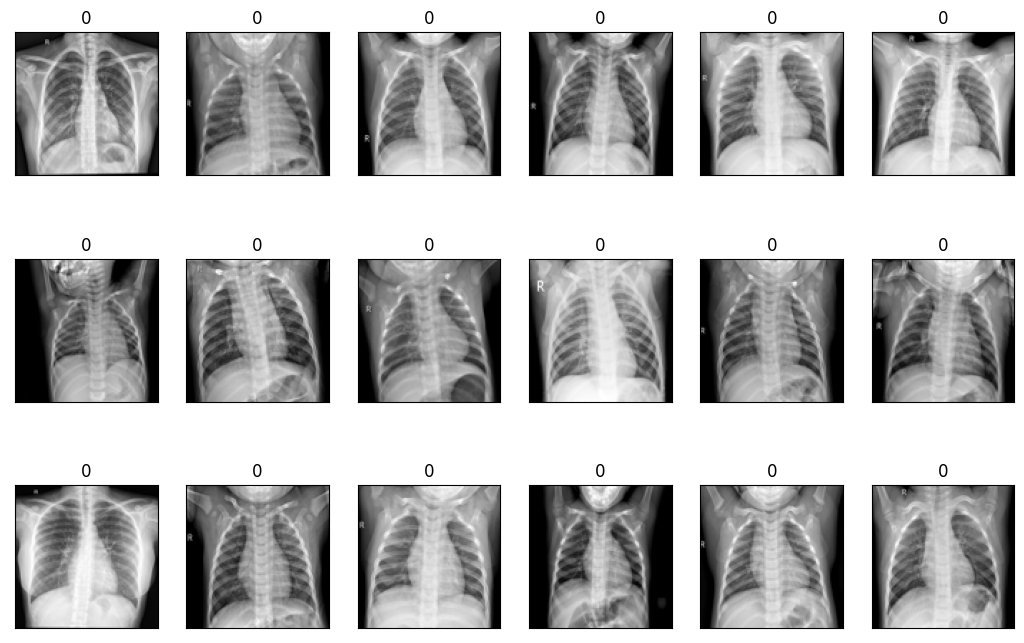

In [4]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(data, classes, 100, 100)

## Evaluation metric
---
##### We chose to use the F1-score metric to account for the false negatives (recall) and false positives (precision) when evaulating our unbalanced unbalanced dataset. In the world of medicine and diagnostics, both false negatives and false positives are extremely important when evaluating a patient. We don't want to wrongly diagnose a patient with pneumonia, and we wouldn't want to wrongly diagnose a patient's lungs as healthy. With the F1-score, we have a better metric to minimize both false ocurrences. Additionally, our dataset is unbalanced in favor of normal lung images. The F1-score suits unbalanced datasets because it is calculated as a harmonic mean of precision and recall.

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

# F1-score is no longer supported in keras so we must make a F1-score function
# From https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

2022-12-04 19:01:12.804574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Divide data into training and testing
---
##### To divide our data into training and testing, we will use Stratified K-fold cross validation. We chose this method because we need to account for the imbalance of normal images and pneumonia images. A stratified split will create folds with balanced occurences of normal and pneumonia images. Using a K-fold split is beneficial for our small dataset because it will better assist our model with generalization. A K-fold split will help reduce variance and allow the model to fit with each fold.

In [6]:
from sklearn.model_selection import StratifiedKFold

X = data
y = np.asarray(classes)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# 2. Modeling
---
## Data Expansion
---
##### For data augmentation, we are using the keras ImageDataGenerator. We chose this method as a preprocessing technique to shift image heights and widths as well as rotate images. Shifting images can possibly remove unwanted effects of non-uniform image shapes before processing. Including a small rotational adjustment can resemble x-ray images that were not positioned the same as other images but still share a similar orientation. We did not flip images because our dataset images all have similar orientations such as heart position and body structure.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05)

datagen.fit(X)

## Model 1


In [8]:
#helper function to print plots of evaluation metric and loss function over # of epochs
def plot_history(hist):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title('Evaluation Metric')
    plt.plot(hist.history['f1'], label='Training F1')
    plt.plot(hist.history['val_f1'], label='Validation F1')
    plt.ylabel('F1-Score')
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(False)
    
    plt.subplot(1,2,2)
    plt.title('Loss Function')
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(False)
    plt.show()

In [9]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

In [ ]:
# def first_model():
#     reg = l2(l2_lambda)
#     cnn = Sequential()

#     cnn.add(Conv2D(filters=32,
#                 kernel_size=(3,3),
#                 kernel_regularizer=reg,
#                 padding='same',
#                 activation='relu'))
#     cnn.add(Conv2D(filters=32,
#                 kernel_size=(3,3),
#                 kernel_regularizer=reg,
#                 padding='same',
#                 activation='relu'))
#     cnn.add(MaxPooling2D(pool_size=(2, 2)))

#     cnn.add(Conv2D(filters=64,
#                 kernel_size=(3,3),
#                 kernel_regularizer=reg,
#                 padding='same',
#                 activation='relu'))
#     cnn.add(Conv2D(filters=64,
#                 kernel_size=(3,3),
#                 kernel_regularizer=reg,
#                 padding='same',
#                 activation='relu'))
#     cnn.add(MaxPooling2D(pool_size=(2, 2)))

#     cnn.add(Dropout(0.25))
#     cnn.add(Flatten())
#     cnn.add(Dense(128, activation='relu',
#                 kernel_regularizer=reg))
#     cnn.add(Dropout(0.5))
#     cnn.add(Dense(1, activation='sigmoid',
#                 kernel_regularizer=reg))

#     cnn.compile(loss='binary_crossentropy',
#                 optimizer='rmsprop',
#                 metrics=[f1])
    
#     return cnn

In [ ]:
# def build_model():
#     fold_no = 0
#     histories = []
#     eval_scores = []
#     for train_index, test_index in kfold.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         cnn = miro_model()

#         print('Fold',fold_no+1)
#         print('')
        
#         history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
#                             steps_per_epoch=int(len(X_train)/batch_size),
#                               epochs=epochs, verbose=verbose)        
        
#         print('')
#         scores = []
#         scores = cnn.evaluate(X_test, y_test, verbose=verbose)
#         print('-' * 110)

#         histories.append(history)
#         eval_scores.append(scores)

#         fold_no += 1

#     eval_scores = np.array(eval_scores)
#     print("Average Performance")
#     print("Loss:",round(np.mean(eval_scores[:,0]), 5))
#     print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
#     return histories, eval_scores

In [ ]:
# %%time
# batch_size = 128
# epochs = 15
# l2_lambda = 0.0001
# verbose = 1

# histories, eval_scores = build_model(model=first_model())

## Model 1 - Basic CNN

In [ ]:
def plot_histories(histories):
    plt.figure(figsize=(20,20))
    for fold_no, history in enumerate(histories):
        keys = list(history.history.keys())
        
        plt.subplot(5,3,3*fold_no+1)
        plt.plot(history.history[keys[0]])
        plt.title('Loss function')
        plt.ylabel('Fold #'+str(fold_no))

        plt.subplot(5,3,3*fold_no+2)
        plt.plot(history.history[keys[1]])
        plt.title('Eval Metric')
        plt.ylim(0.5, 1)

In [86]:
def model_2(optimizer, num_filt_layers):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    for num_filters in num_filt_layers:
        cnn.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        kernel_initializer='he_uniform', 
                        kernel_regularizer=reg,
                        padding='same',))
        cnn.add( Activation('relu'))
        cnn.add(BatchNormalization())
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add one layer on flattened output
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.25) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=1,
                  activation='sigmoid',
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))

    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [87]:
def build_model_2(optimizer, num_filt_layers):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_2(optimizer, num_filt_layers)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores

In [88]:
%%time
# Using Adam optimizer and tuning hyper parameters like in the last lab
# Adding batch normalization to speed things up
# he_uniform initializing for relu and glorot_uniform initializing for sigmoid
#------------------------------------------------------------#
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001, epsilon=1e-8)
#------------------------------------------------------------#

batch_size = 128; epochs = 15; l2_lambda = 0.0001; verbose = 1
num_filt_layers = [32,64]

histories, eval_scores = build_model_2(optimizer=adam, num_filt_layers=num_filt_layers)

Fold 1

Epoch 1/15
10/10 [==============================] - 10s 908ms/step - loss: 11.0505 - f1: 0.2097
Epoch 2/15
10/10 [==============================] - 9s 883ms/step - loss: 0.6190 - f1: 0.3039
Epoch 3/15
10/10 [==============================] - 8s 838ms/step - loss: 0.3787 - f1: 0.5211
Epoch 4/15
10/10 [==============================] - 11s 1s/step - loss: 0.3523 - f1: 0.6714
Epoch 5/15
10/10 [==============================] - 11s 1s/step - loss: 0.2588 - f1: 0.7911
Epoch 6/15
10/10 [==============================] - 9s 882ms/step - loss: 0.2329 - f1: 0.8243
Epoch 7/15
10/10 [==============================] - 10s 958ms/step - loss: 0.2001 - f1: 0.8387
Epoch 8/15
10/10 [==============================] - 9s 867ms/step - loss: 0.1961 - f1: 0.8553
Epoch 9/15
10/10 [==============================] - 9s 925ms/step - loss: 0.1720 - f1: 0.8858
Epoch 10/15
10/10 [==============================] - 9s 936ms/step - loss: 0.1839 - f1: 0.8838
Epoch 11/15
10/10 [==============================] -

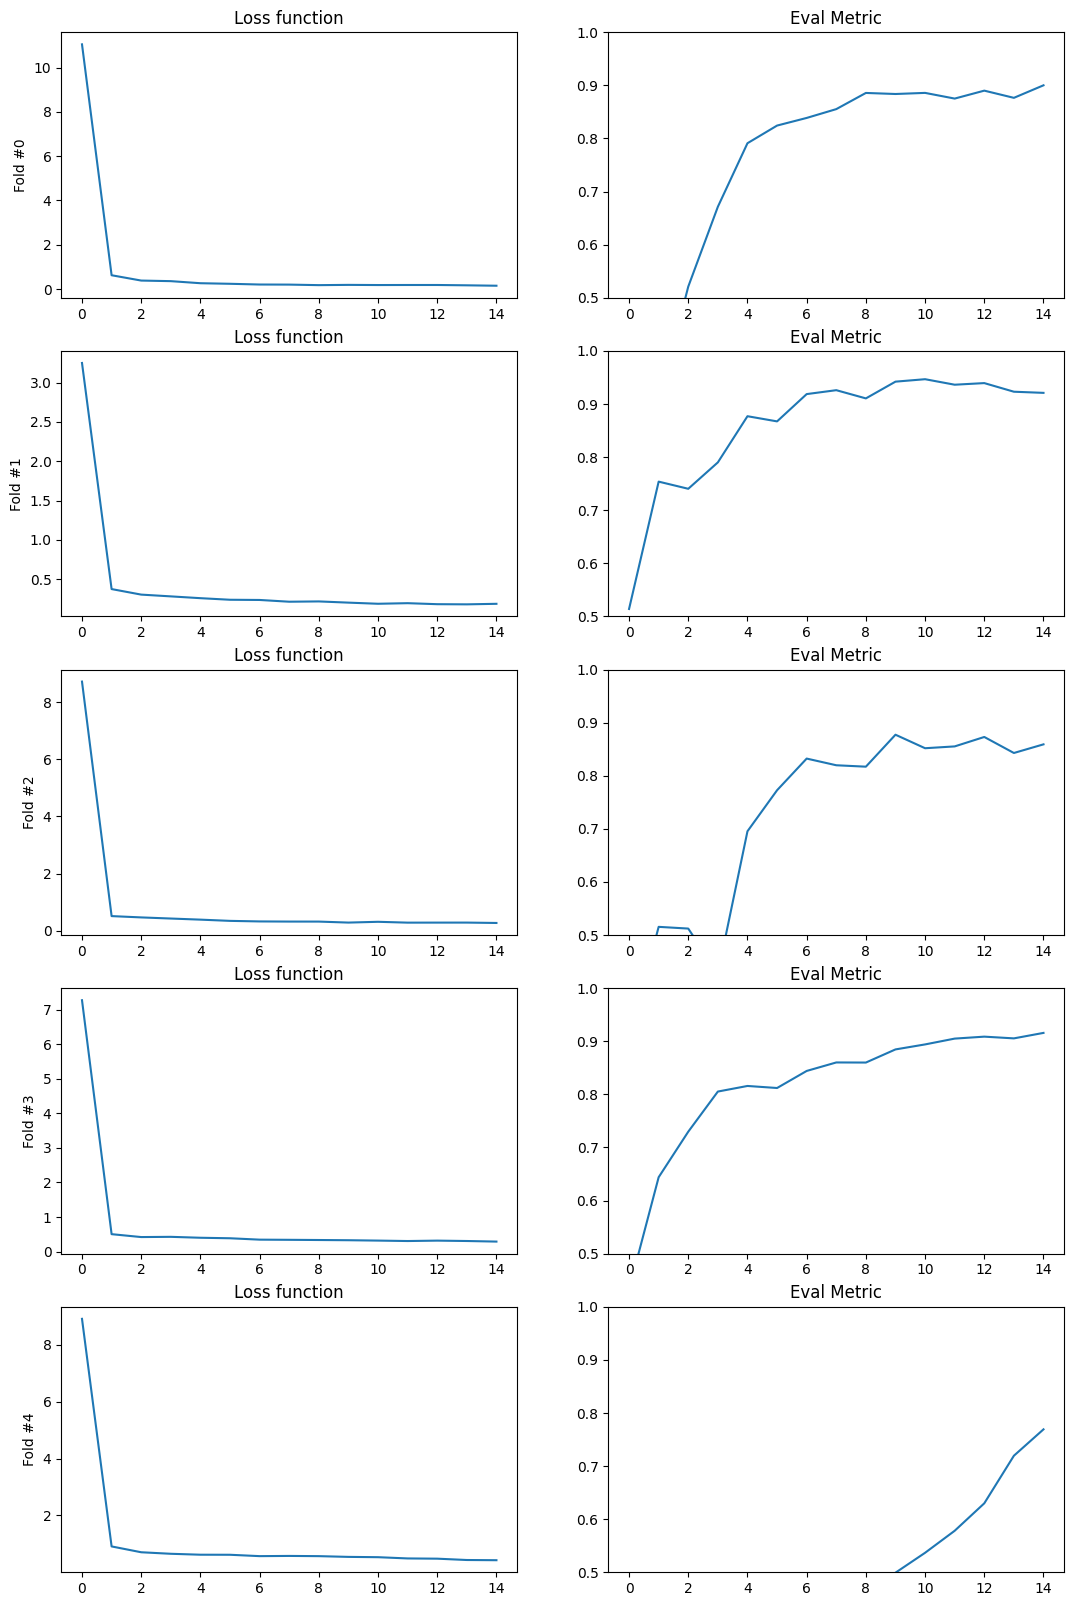

In [89]:
plot_histories(histories)

In [90]:
# Now lets double the number of conv/pool layers

num_filt_layers = [32,32,64,64]

histories2, eval_scores2 = build_model_2(optimizer=adam, num_filt_layers=num_filt_layers)

Fold 1

Epoch 1/15
10/10 [==============================] - 10s 868ms/step - loss: 1.3298 - f1: 0.4958
Epoch 2/15
10/10 [==============================] - 10s 945ms/step - loss: 0.3250 - f1: 0.6356
Epoch 3/15
10/10 [==============================] - 9s 891ms/step - loss: 0.2681 - f1: 0.8450
Epoch 4/15
10/10 [==============================] - 10s 970ms/step - loss: 0.1992 - f1: 0.9110
Epoch 5/15
10/10 [==============================] - 9s 929ms/step - loss: 0.1884 - f1: 0.8961
Epoch 6/15
10/10 [==============================] - 9s 890ms/step - loss: 0.1535 - f1: 0.9479
Epoch 7/15
10/10 [==============================] - 9s 885ms/step - loss: 0.1439 - f1: 0.9508
Epoch 8/15
10/10 [==============================] - 9s 881ms/step - loss: 0.1407 - f1: 0.9502
Epoch 9/15
10/10 [==============================] - 9s 892ms/step - loss: 0.1282 - f1: 0.9637
Epoch 10/15
10/10 [==============================] - 8s 815ms/step - loss: 0.1374 - f1: 0.9627
Epoch 11/15
10/10 [=============================

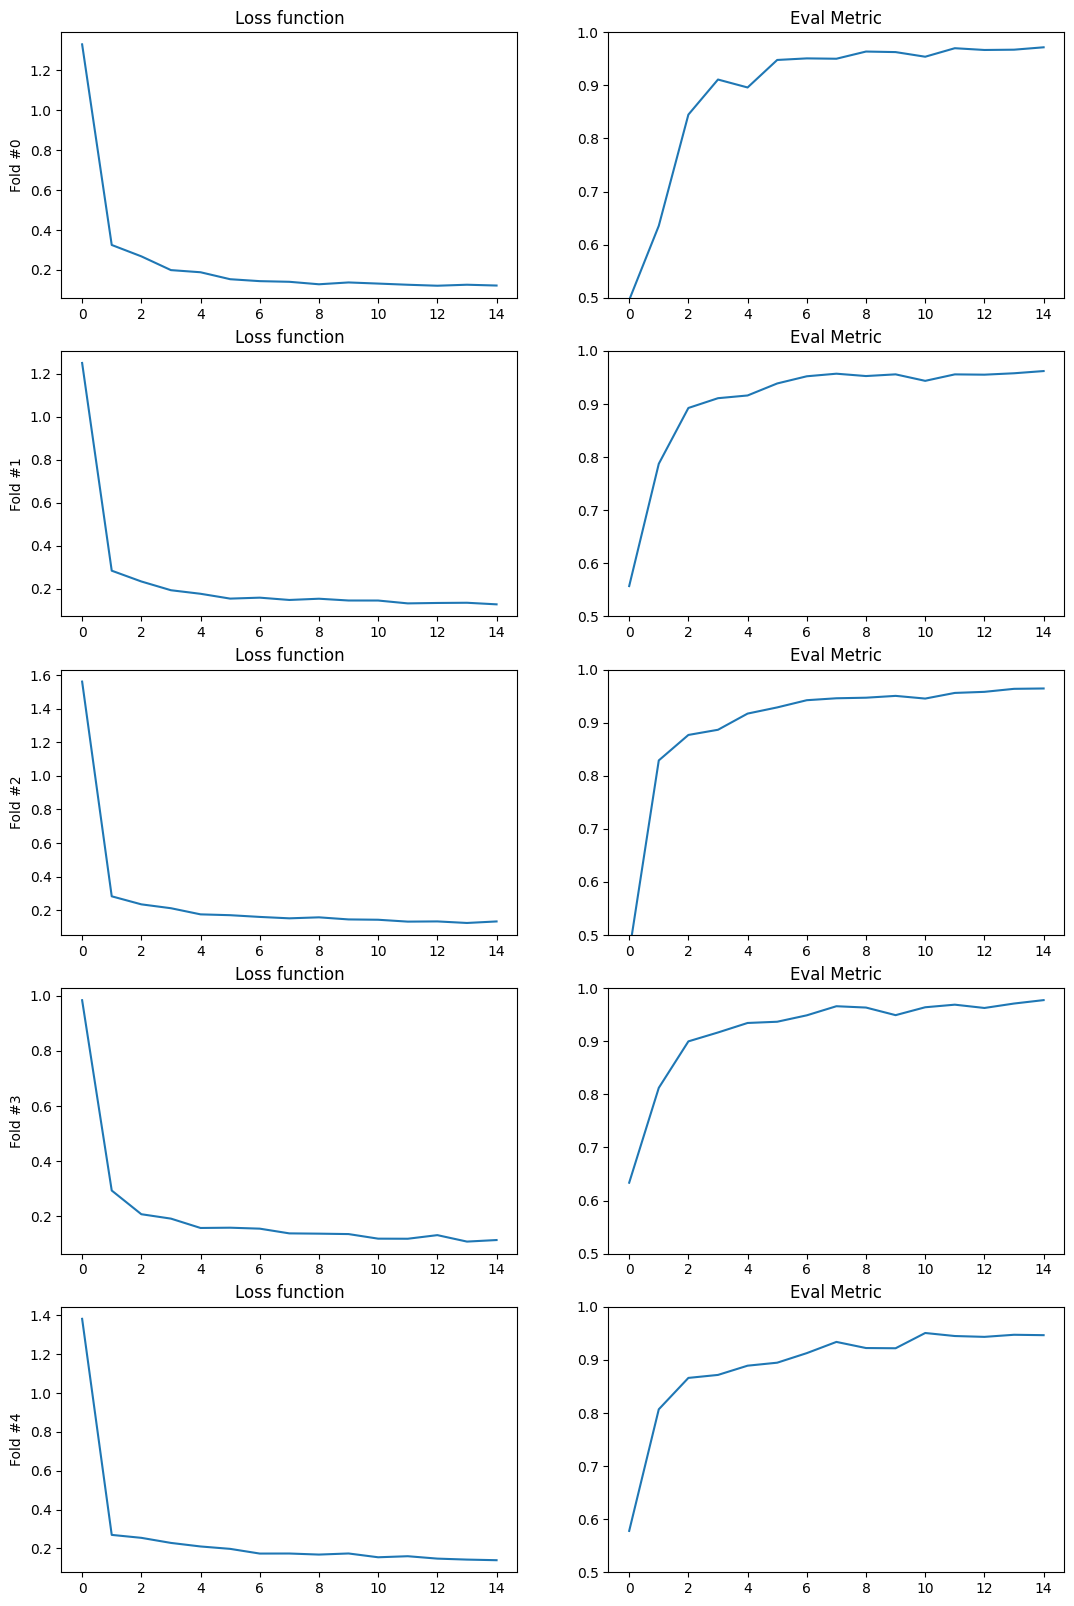

In [91]:
plot_histories(histories2)

---
##### By doubling the number of layers, but keeping the same number of filters, our new model variant performs considerably better insofar that we see convergence for each fold and our evaluation metric is comparatively higher for each iteration. Also, run time appears to remain the same. 
---

## Model 2: Alexnet "style" Architecture (reducing number of filters)

In [108]:
def model_3(optimizer, num_filt_layers):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    # Conv 1 - Max Pool 1
    cnn.add( Conv2D(filters=num_filt_layers[0], 
                    kernel_size=(3,3), # reducing kernel size for run time
                    kernel_initializer='he_uniform', 
                    kernel_regularizer=reg,
                    padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3)))
    
    # Conv 2 - Max Pool 2
    cnn.add( Conv2D(filters=num_filt_layers[1], 
                kernel_size=(3,3), # reducing kernel size for run time
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3)))
    
    # Conv3 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[2], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    
    # Conv4 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[3], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    
    # Conv5 - Max Pool 3 - Dropout 1
    cnn.add( Conv2D(filters=num_filt_layers[4], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3)))
    cnn.add(Dropout(0.5))


    # Full connected and dropout layers
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    cnn.add(Dense(units=1,
                  activation='sigmoid', # using sigmoid here for binary classification
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))
    
    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [109]:
def build_model_3(optimizer, num_filt_layers=[96, 256, 384, 384, 256]):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_3(optimizer, num_filt_layers)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores

In [110]:
num_filt_layers=[96/8, 256/8, 384/8, 384/8, 256/8] # taking alexnet params and scaling them down for run time
histories3, eval_scores3 = build_model_3(optimizer=adam)

Fold 1

Epoch 1/15
10/10 [==============================] - 31s 3s/step - loss: 1.8470 - f1: 0.4352
Epoch 2/15
10/10 [==============================] - 32s 3s/step - loss: 0.8658 - f1: 0.7386
Epoch 3/15
10/10 [==============================] - 30s 3s/step - loss: 0.8203 - f1: 0.8339
Epoch 4/15
10/10 [==============================] - 30s 3s/step - loss: 0.7715 - f1: 0.8738
Epoch 5/15
10/10 [==============================] - 33s 3s/step - loss: 0.7838 - f1: 0.8730
Epoch 6/15
10/10 [==============================] - 29s 3s/step - loss: 0.7736 - f1: 0.8584
Epoch 7/15
10/10 [==============================] - 29s 3s/step - loss: 0.7336 - f1: 0.9041
Epoch 8/15
10/10 [==============================] - 30s 3s/step - loss: 0.7440 - f1: 0.9006
Epoch 9/15
10/10 [==============================] - 30s 3s/step - loss: 0.6967 - f1: 0.9180
Epoch 10/15
10/10 [==============================] - 31s 3s/step - loss: 0.7014 - f1: 0.8955
Epoch 11/15
10/10 [==============================] - 34s 3s/step - loss

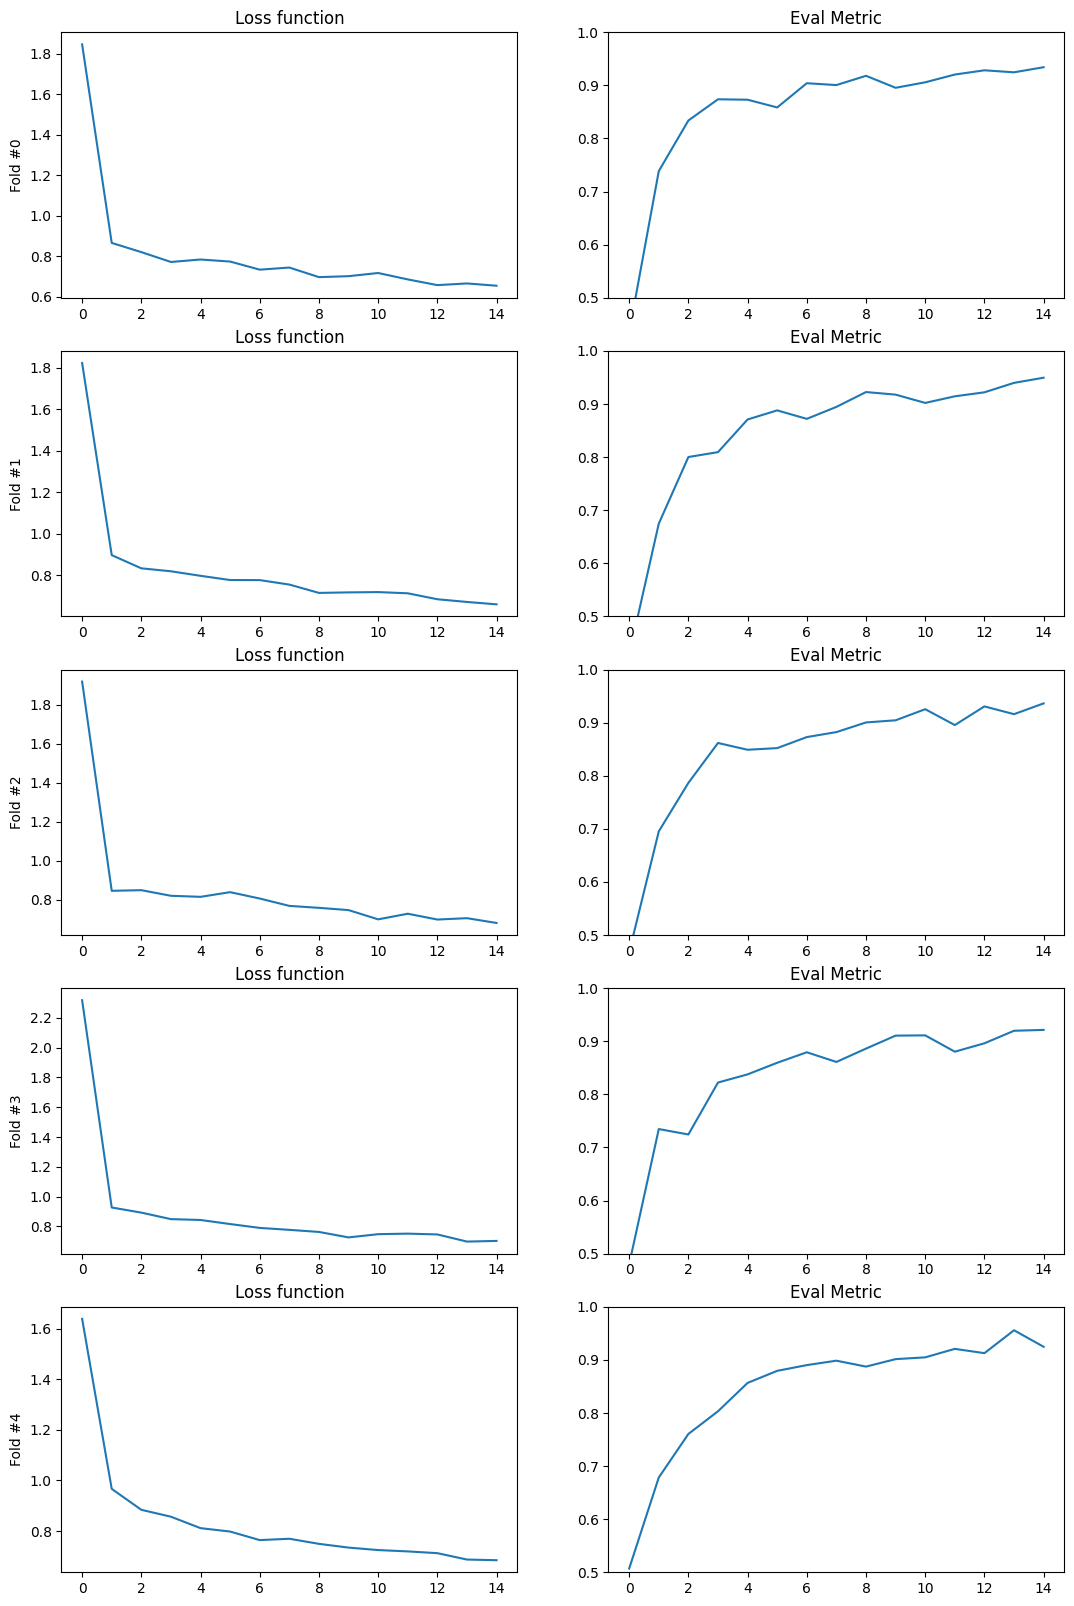

In [115]:
plot_histories(histories3)

---
##### Alexnet is clearly not performing as good as our previous cnn. The eval metric is still exhibiting "spikey" behaviour and it is comparatively lower. We infer that this dip in productivity is predicated on our action of reducing the number of filters per conv layer, and not on the actual architecture itself. Since this is a HW assignment, we do not have the luxury of time of letting this run on its original params. Given this, let's see if we can speed up run time while tuning other params.
---

In [116]:
# Now lets change the kernel size to (1,1) for the conv layers without max pooling and change the pool size of the max pool layers to (2,2)
# Also, since the model isn't performing better let's also just remove the last 2 conv layers
def model_3_alt(optimizer, num_filt_layers):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    # Conv 1 - Max Pool 1
    cnn.add( Conv2D(filters=num_filt_layers[0], 
                    kernel_size=(3,3), # reducing kernel size for run time
                    kernel_initializer='he_uniform', 
                    kernel_regularizer=reg,
                    padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 2 - Max Pool 2
    cnn.add( Conv2D(filters=num_filt_layers[1], 
                kernel_size=(3,3), # reducing kernel size for run time
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv3 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[2], 
                kernel_size=(1,1), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())

    # Full connected and dropout layers
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    cnn.add(Dense(units=1,
                  activation='sigmoid', # using sigmoid here for binary classification
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))
    
    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [117]:
def build_model_3_alt(optimizer, num_filt_layers=[96, 256, 384]):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_3_alt(optimizer, num_filt_layers)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores

In [120]:
num_filt_layers=[96/8, 256/8, 384/8] # taking alexnet params and scaling them down for run time

histories4, eval_scores4 = build_model_3_alt(optimizer=adam, num_filt_layers=num_filt_layers)

Fold 1

Epoch 1/15
10/10 [==============================] - 6s 486ms/step - loss: 7.0700 - f1: 0.4287
Epoch 2/15
10/10 [==============================] - 5s 462ms/step - loss: 0.8825 - f1: 0.6804
Epoch 3/15
10/10 [==============================] - 5s 453ms/step - loss: 0.6676 - f1: 0.7769
Epoch 4/15
10/10 [==============================] - 5s 462ms/step - loss: 0.6213 - f1: 0.8525
Epoch 5/15
10/10 [==============================] - 5s 456ms/step - loss: 0.6217 - f1: 0.8723
Epoch 6/15
10/10 [==============================] - 5s 451ms/step - loss: 0.5860 - f1: 0.8479
Epoch 7/15
10/10 [==============================] - 5s 458ms/step - loss: 0.5842 - f1: 0.8501
Epoch 8/15
10/10 [==============================] - 5s 450ms/step - loss: 0.5794 - f1: 0.8632
Epoch 9/15
10/10 [==============================] - 5s 444ms/step - loss: 0.5484 - f1: 0.8617
Epoch 10/15
10/10 [==============================] - 5s 458ms/step - loss: 0.5656 - f1: 0.8960
Epoch 11/15
10/10 [==============================] 

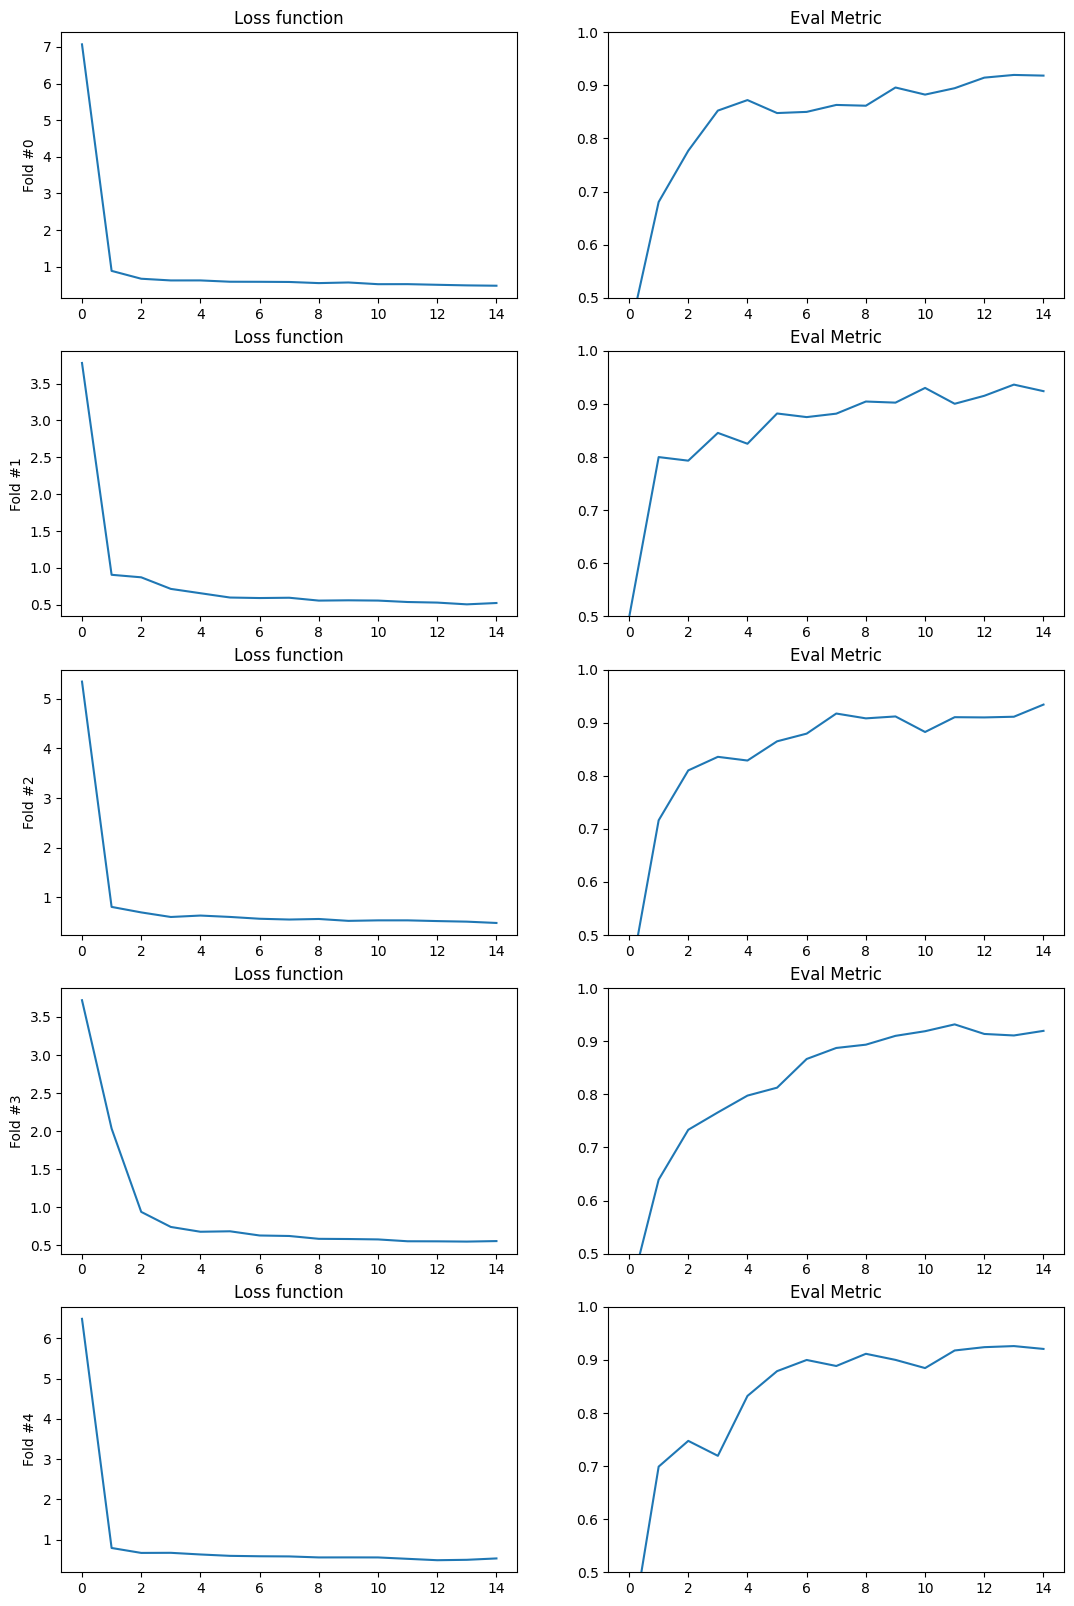

In [121]:
plot_histories(histories4)

---
##### Evidently, by removing the last 2 conv layers, and reducing both pool sizes and kernel sizes we have effectively reduced the run time while also reducing the evaluation metric compared to our model_3. Out of curiousity, let's see if increasing the number of filters would improve our evaluation metric.
---

In [ ]:
num_filt_layers=[96/4, 256/4, 384/4] # taking alexnet params and scaling them down for run time

histories5, eval_scores5 = build_model_3_alt(optimizer=adam, num_filt_layers=num_filt_layers)

Fold 1

Epoch 1/15
10/10 [==============================] - 10s 870ms/step - loss: 5.0950 - f1: 0.5483
Epoch 2/15
10/10 [==============================] - 9s 915ms/step - loss: 1.7576 - f1: 0.8163
Epoch 3/15
 8/10 [=======================>......] - ETA: 1s - loss: 1.6051 - f1: 0.8742

# Exceptional Work